# Functional Encryption - Classification and information leakage
 
We would like to have a measure of the leakage with cryptology notions. In particular, we will look at the notion of [advantage](https://en.wikipedia.org/wiki/Advantage_(cryptography)) in the distinction task.

> An adversary's advantage is a measure of how successfully it can attack a cryptographic algorithm, by distinguishing it from an idealized version of that type of algorithm -- Wikipedia


Let $Q$ be the real quadratic network, and let $Q_{ideal}$ be the real one with no collateral leakage (ie accuracy on the collateral task would be 50%). The adversary $F$ is a probabilistic algorithm given $Q$ or $Q_{ideal}$ as input and which outputs 1 or 0 (depending on the font). $F$'s job is to distinguish $Q$ from $Q_{ideal}$ based on making queries given data samples. We say: $Adv(F)=|\Pr[F(Q)=1]-\Pr[F(Q_{ideal})=1]|$

Because the adversary is sharp, it will fix a digit and try to distinguish on this one the font used. We chose $6$ because we are fair and wanted a digit of average difficulty.

So to be clear: when building the resistance, we must provide equal resistance against all kind of digits for the couple of fonts selected, but the adversary can be specialized in a single digit. Therefore the problem is a bit unbalanced and we expect worse results compared to the Part 6. Therefore, we already start with longer sabotage and attack phases to get a more realistic view of what we should expect.

# 8. Collateral Learning assessed with Advantage


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import show_results
# We now import from the collateral module
from learn import collateral

In [58]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10 # PUT 50 to get a proper resistance, but expect a long computation!
        self.new_adversary_epochs = 50 
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 300

In [4]:
PRIVATE_OUTPUT_SIZE = 10
N_CHARS = 10
N_FONTS = 2

## 8.1 Loading $Q$ with resistance

In [110]:
class CollateralNet(nn.Module):
    def __init__(self):
        super(CollateralNet, self).__init__()
        self.proj1 = nn.Linear(784, 40)
        self.diag1 = nn.Linear(40, PRIVATE_OUTPUT_SIZE, bias=False)

        # --- FFN for characters
        self.lin1 = nn.Linear(PRIVATE_OUTPUT_SIZE, 32)
        self.lin2 = nn.Linear(32, N_CHARS)

        # --- Junction
        self.jct = nn.Linear(PRIVATE_OUTPUT_SIZE, 784)

        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)
        
        
        # FFN for families
        self.lin3 = nn.Linear(PRIVATE_OUTPUT_SIZE, 64)
        self.lin4 = nn.Linear(64, 32)
        self.lin5 = nn.Linear(32, 16)
        self.lin6 = nn.Linear(16, 8)
        self.lin7 = nn.Linear(8, N_CHARS)

    def quad(self, x):
        # --- Quadratic
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

    def char_net(self, x):
        # --- FFN
        x = F.relu(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

    def font_net(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)

        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.char_net(x)
        return F.log_softmax(x, dim=1)

    def forward_font(self, x):
        x = self.quad(x)
        x = self.font_net(x)
        return F.log_softmax(x, dim=1)
    
    # We add the ability to freeze some layers to ensure that the collateral task does
    # not modify the quadratic net
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.jct, self.fc1, self.fc2, self.conv1, self.conv2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params

    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False

    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

In [111]:
def build_resistance(model, alpha=0):
    """
    Perform a dual learning phase with sabotage
    """
    args = Parser()
    # We are just building Q so we don't need the 3rd phase, it will be assessed later!
    args.new_adversary_epochs = 0
    
    train_loader, test_loader = collateral.get_data_loaders(args)

    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + args.new_adversary_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")
        recover = epoch > args.epochs + args.sabotage_epochs
        if recover:
            print("(recover)")
        collateral.train(
            args, model, train_loader, optimizer, epoch, alpha, 
            initial_phase, perturbate, recover, False
        )
        test_perf_char, test_perf_font = collateral.test(args, model, test_loader, False)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

We could use the same $Q$ than in part 6, but we could like a better resistance so we rebuild a new one.

In [112]:
path = '../data/models/quadconvnet_part8_out10.pt'
path = 'models/test_quadconvnet_0.5_0.002_1.7_10.pt'
model = CollateralNet()
results = {}

try:
    model.load_state_dict(torch.load(path))
    model.eval()
    print('Model loaded!')
except FileNotFoundError:
    print('Computing model...')
    alpha=1.7
    test_perfs_char_perturbate, test_perfs_font_perturbate = build_resistance(model, alpha=alpha)
    results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_perturbate
    results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_perturbate
    
    model.results = results
    # save model
    torch.save(model.state_dict(), path)

Model loaded!


## 8.2 Testing distinguishability againts multiples nets

We load the `Q` net that we have thoroughly built and it will be given to our new network structure

In [113]:
quadratic_model = model
quadratic_model.freeze('quad')

We now perform only the last phase with the new adversary, note that we change the data loader

In [122]:
fonts = ['cursive', 'Georgia']
letter = "6"

def evaluate_resistance(model, alpha=0):
    args = Parser()
    
    train_loader, test_loader = collateral.data.get_collateral_data_loaders(args, *fonts, letter)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.new_adversary_epochs + 1):
        
        print(model.proj1.weight[30:35, 60])
        initial_phase = False
        perturbate = False
        recover = True
        
        new_adversary = True
        
        collateral.train(
            args, model, train_loader, optimizer, epoch, alpha,
            initial_phase, perturbate, recover, new_adversary
        )
        test_perf_char, test_perf_font = collateral.test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

Here is the basic structure of a network like those seen previously. There is a quadratic part which inherits from the `Q` loaded, and a method `conv_font` is left empty so that we can provide arbitrary adversary by inheriting from this `BaseNet`.

In [123]:
class BaseNet(nn.Module):
    def __init__(self, quadratic_model):
        super(BaseNet, self).__init__()
        self.proj1 = quadratic_model.proj1
        self.diag1 = quadratic_model.diag1
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_font(self, x):
        pass
    
    def forward_adv_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

In [124]:
resistance_reports = {}

### 6.2.1 Fully connected models 

Here we inherit from BaseNet and we only have to specify `conv_font` and declare the layers used.

In [125]:
class FFNet(BaseNet):
    def __init__(self, architecture, quadratic_model):
        super(FFNet, self).__init__(quadratic_model)
        # --- FFNs for font families
        self.architecture = architecture
        n_layer = len(architecture) + 1
        input_size = PRIVATE_OUTPUT_SIZE
        for i_layer, output_size in enumerate(architecture):
            setattr(self, f"net_{i_layer}", nn.Linear(input_size, output_size))
            input_size = output_size
        setattr(self, f"net_{n_layer}", nn.Linear(input_size, N_FONTS)) 
    
    def conv_font(self, x):
        # --- FFN
        architecture = self.architecture
        n_layer = len(architecture) + 1
        for i_layer, output_size in enumerate(architecture):
            linear = getattr(self, f"net_{i_layer}")
            x = F.relu(linear(x))
        linear = getattr(self, f"net_{n_layer}")  
        x = linear(x)
        return x
        
        

In [126]:
architectures = [[64, 32, 16, 8], [32, 16, 8], [24, 12], [64], [32], [16]]

for architecture in architectures:
    print('\n-----', architecture)
    model = FFNet(architecture, quadratic_model)
    print(model)
    _, test_perfs_font = evaluate_resistance(model)
    
    architecture = ':'.join(map(str, [8] + architecture + [N_FONTS]))
    resistance_reports[f"Collateral task with net {architecture}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of FFNs with CNN protection")



----- [64, 32, 16, 8]
FFNet(
  (proj1): Linear(in_features=784, out_features=40, bias=True)
  (diag1): Linear(in_features=40, out_features=10, bias=False)
  (net_0): Linear(in_features=10, out_features=64, bias=True)
  (net_1): Linear(in_features=64, out_features=32, bias=True)
  (net_2): Linear(in_features=32, out_features=16, bias=True)
  (net_3): Linear(in_features=16, out_features=8, bias=True)
  (net_5): Linear(in_features=8, out_features=2, bias=True)
)
Training set 60000 items
Testing set  10000 items
tensor([-0.0020, -0.0108,  0.0148, -0.0320, -0.0066])
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.718810
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.684452
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.686363
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.688123

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5239/10000 (52.39%)
tensor([-0.0020, -0.0108,  0.0148, -0.0320, -0.

KeyboardInterrupt: 

### 6.2.2 CNN models

In [14]:
class CNNet(BaseNet):
    def __init__(self, nn_modules, quadratic_model):
        super(CNNet, self).__init__(quadratic_model)
        # --- CNNs for font families
        self.nn_modules = nn_modules
        setattr(self, "net_0", nn.Linear(PRIVATE_OUTPUT_SIZE, 784))
        for i_layer, nn_module in enumerate(nn_modules):
            setattr(self, f"net_{i_layer + 1}", nn_module)
    
    def conv_font(self, x):
        switched_from_conv_lin = False
        out_channels = []
        # Make the junction
        linear = getattr(self, "net_0")  
        x = linear(x)
        x = x.view(-1, 1, 28, 28)
        # --- CNN
        for i_layer, _ in enumerate(self.nn_modules):
            layer = getattr(self, f"net_{i_layer + 1}")
            if isinstance(layer, nn.Conv2d): # Conv layer
                x = F.relu(layer(x))
                x = F.max_pool2d(x, 2, 2)
                out_channels.append(layer.out_channels)
            else: # Linear layer
                if not switched_from_conv_lin:
                    x = x.view(-1, 4*4*out_channels[-1])
                    switched_from_conv_lin = True
                if i_layer < len(self.nn_modules) - 1:
                    x = F.relu(layer(x))
                else:
                    x = layer(x)
        return x
         

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.911390
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.667801
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.685084
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.683268

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 5860/10000 (58.60%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.650930
Train Epoch: 2 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.662303
Train Epoch: 2 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 0.687251
Train Epoch: 2 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 0.638498

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 6114/10000 (61.14%)
Train Epoch: 3 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 0.664561
Train Epoch: 3 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 0.618946
Train Epoch: 3 [38400/60000 (64%)]	Lo

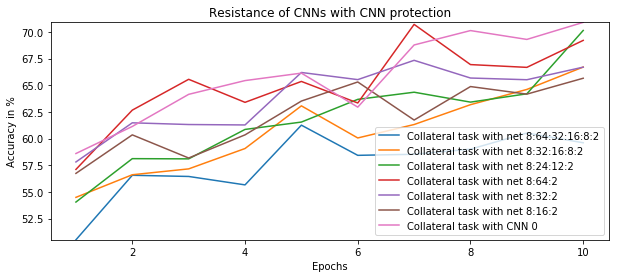

In [15]:
architectures = [
    (
        nn.Conv2d(1, 20, 5, 1),
        nn.Conv2d(20, 50, 5, 1),
        nn.Linear(4*4*50, 500),
        nn.Linear(500, N_FONTS)
    )
]
"""
,
    (
        nn.Conv2d(1, 30, 4, 1),
        nn.Conv2d(30, 100, 4),
        nn.Linear(100 * 4 * 4, 1000),
        nn.Linear(1000, 100),
        nn.Linear(100, N_FONTS)
    )
"""
for i, architecture in enumerate(architectures):
    model = CNNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    resistance_reports[f"Collateral task with CNN {i}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of CNNs with CNN protection")

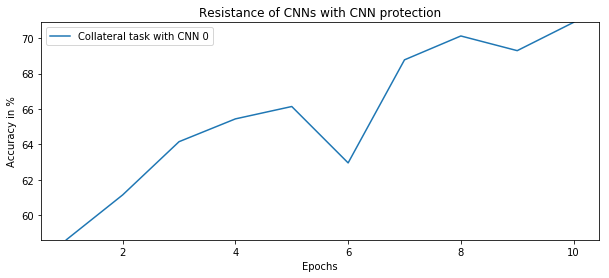

In [16]:
show_results(
    {k:v for k, v in resistance_reports.items() if 'CNN' in k}, 
    title="Resistance of CNNs with CNN protection"
)

## 6.3 Non-NN models

We now test many models from the sklearn library

### Data preparation

In [17]:
transform = BaseNet(quadratic_model)

In [18]:
def get_input_onehot_labels(dataset, label="font", one_hot=True):
    data_input = dataset.tensors[0]
    label_idx = {'char': 0, 'font': 1}[label]
    label_size = {'char': N_CHARS, 'font': N_FONTS}[label]
    labels = dataset.tensors[1][:, label_idx].view(-1, 1)
    
    data_label_onehot = torch.zeros(len(labels), label_size)
    data_label_onehot.scatter_(1, labels, 1)
    
    return data_input, labels, data_label_onehot
    

Get dataset and transform in one hot vector

In [19]:
train_dataset, test_dataset = collateral.data.get_datasets(None, None)
train_input, train_label, train_label_one_hot = get_input_onehot_labels(train_dataset, label="font")
test_input, test_label, test_label_one_hot = get_input_onehot_labels(test_dataset, label="font")

Training set 60000 items
Testing set  10000 items


Apply the quadratic model transformation

In [20]:
train_input = transform.quad(train_input).detach().numpy()
test_input = transform.quad(test_input).detach().numpy()

In [21]:
train_label = train_label.reshape(-1)
test_label = test_label.reshape(-1)

In [22]:
train_input.shape, train_label.shape

((60000, 10), torch.Size([60000]))

In [23]:
ALL = train_input.shape[0]
CPOWER = 'LOW'

In [24]:
from sklearn import linear_model
from sklearn import kernel_ridge
from sklearn import svm

In [25]:
def evaluate_sklearn(reg, one_hot=True, limit=int(10e10)):
    train_labels = {True: train_label_one_hot, False: train_label}[one_hot]
    reg.fit(train_input[:limit], train_labels[:limit].detach().numpy()) 
    output = reg.predict(test_input)
    if one_hot:
        pred = torch.tensor(output).argmax(1, keepdim=True)
    else:
        if isinstance(output, list):
            pred = torch.tensor(list(map(round, output))).long().view(-1, 1)
        else:
            pred = torch.tensor(np.round(output)).long().view(-1, 1)
    y = test_label.view_as(pred)
    acc = pred.eq(y).sum().item() / len(pred)
    return acc

### Linear models

In [26]:
reg = linear_model.Ridge(alpha=.9)
acc = evaluate_sklearn(reg)
print(acc)
resistance_reports['linear model Ridge'] = acc * 100

0.502


In [27]:
reg = linear_model.RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100], cv=5)
acc = evaluate_sklearn(reg)
print(acc)

0.502


In [28]:
reg = linear_model.Lasso(alpha=0.1)
acc = evaluate_sklearn(reg)
print(acc)
resistance_reports['linear model Lasso'] = acc * 100

0.5005


In [29]:
reg = linear_model.LassoLars(alpha=0.1)
acc = evaluate_sklearn(reg)
print(acc)

0.5005


In [30]:
reg = linear_model.BayesianRidge()
acc = evaluate_sklearn(reg, one_hot=False)
print(acc)

0.5032


In [31]:
reg = linear_model.LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial', max_iter=1000)
acc = evaluate_sklearn(reg, one_hot=False)
print(acc)
resistance_reports['logistic regression'] = acc * 100

0.5019


In [32]:
reg = linear_model.LogisticRegressionCV(cv=5, random_state=0, multi_class='multinomial')
acc = evaluate_sklearn(reg, one_hot=False)
print(acc)

0.5031


### Quadratic Discriminant Analysis

In [33]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [34]:
clf = QuadraticDiscriminantAnalysis()
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Quadratic Discriminant Analysis'] = acc * 100

0.5465


### Kernel Ridge

In [35]:
clf = kernel_ridge.KernelRidge(alpha=1.0)
limit = {'LOW': 15000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)

/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:165: LinAlgWarning: Ill-conditioned matrix (rcond=8.07553e-11): result may not be accurate.
  overwrite_a=False)


0.5053


### SVM

In [36]:
clf = svm.SVC(gamma='scale', kernel='linear')
limit = {'LOW': 5000, 'MEDIUM': 15000, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])

print(acc)

0.5108


In [37]:
clf = svm.SVC(gamma='scale', kernel='rbf')
limit = {'LOW': 20000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)
resistance_reports['SVM (rbf)'] = acc * 100

0.5574


In [38]:
clf = svm.SVC(gamma='scale', kernel='poly', coef0=0)
limit = {'LOW': 20000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)

0.5065


In [39]:
clf = svm.SVC(gamma='scale', kernel='sigmoid', coef0=0)
limit = {'LOW': 20000, 'MEDIUM': ALL, 'HIGH': ALL}
acc = evaluate_sklearn(clf, one_hot=False, limit=limit[CPOWER])
print(acc)

0.4882


### Stochastic gradient Descent

In [40]:
clf = linear_model.SGDClassifier(loss="hinge", penalty="l2")
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['SGDClassifier'] = acc * 100

0.5003


/Users/tryffel/code/env/pysyft/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [41]:
clf = linear_model.SGDClassifier(max_iter=1000, tol=1e-3, loss="log")
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

0.4919


### K-Neighbors Classifier

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
clf = KNeighborsClassifier(n_neighbors=7)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['K-Neighbors Classifier'] = acc * 100

0.8018


### Gaussian process (not scalable)

In [44]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [45]:
kernel = 1.0 * RBF(1.0)
gpc = GaussianProcessClassifier(kernel=kernel,
        random_state=0)
limit = {'LOW': 1700, 'MEDIUM': 5000, 'HIGH': 20000}
acc = evaluate_sklearn(gpc, one_hot=False, limit=limit[CPOWER])
print(acc)
resistance_reports['Gaussian process'] = acc * 100

0.6193


### Naive Bayes

In [46]:
from sklearn.naive_bayes import GaussianNB

In [47]:

gnb = GaussianNB()
acc = evaluate_sklearn(gnb, one_hot=False)
print(acc)

0.5326


### Decision Tree Classifier

In [48]:
from sklearn.tree import DecisionTreeClassifier

In [49]:

clf = DecisionTreeClassifier(max_depth=5)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

resistance_reports['Decision Tree Classifier'] = acc * 100

0.5591


### Ensemble methods

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [51]:
clf = RandomForestClassifier(max_depth=30, n_estimators=100, max_features=4)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Random Forest Classifier'] = acc * 100

0.8046


In [52]:
clf = AdaBoostClassifier(n_estimators=200, learning_rate=1.)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['AdaBoost Classifier'] = acc * 100

0.5659


In [53]:
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,
    max_depth=10, random_state=0)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)
resistance_reports['Gradient Boosting Classifier'] = acc * 100

0.6891


### (sklearn) Neural Network

In [54]:
from sklearn.neural_network import MLPClassifier

In [55]:
clf = MLPClassifier(solver='lbfgs', alpha=1,
                    hidden_layer_sizes=(10, 40, 10), random_state=1)
acc = evaluate_sklearn(clf, one_hot=False)
print(acc)

0.5487


## Summary

In [56]:
def print_table(results):
    n_cols = 2
    title_length = 0
    for title in results.keys():
        title_length = max(title_length, len(title))
    result_length = 8
    table_length = 1 + n_cols + title_length + result_length
    sep = '+'.join(
        ['', '-'*title_length, '-'*result_length, '']
    )
    for title, serie in results.items():
        print(sep)
        title = (title + ' '*title_length)[:title_length]
        if isinstance(serie, list):
            result = round(np.mean(serie[-4:]), 2)
        else:
            result = round(serie, 2)
        result = (' ' +str(result) + '%' + ' '*result_length)[:result_length]
        line = '|'.join(
            ['', title, result, '']
        )
        print(line)
    print(sep)

In [57]:
print_table(resistance_reports)

+---------------------------------------+--------+
|Collateral task with net 8:64:32:16:8:2| 59.42% |
+---------------------------------------+--------+
|Collateral task with net 8:32:16:8:2   | 63.96% |
+---------------------------------------+--------+
|Collateral task with net 8:24:12:2     | 65.53% |
+---------------------------------------+--------+
|Collateral task with net 8:64:2        | 68.38% |
+---------------------------------------+--------+
|Collateral task with net 8:32:2        | 66.31% |
+---------------------------------------+--------+
|Collateral task with net 8:16:2        | 64.11% |
+---------------------------------------+--------+
|Collateral task with CNN 0             | 69.78% |
+---------------------------------------+--------+
|linear model Ridge                     | 50.2%  |
+---------------------------------------+--------+
|linear model Lasso                     | 50.05% |
+---------------------------------------+--------+
|logistic regression           

### Compative results

If you kept sabotage epochs at 10 you might have high collateral accuracies.
Here is the table you would get after a long resistance phase:

```
+---------------------------------------+--------+
|Collateral task with net 8:64:32:16:8:2| 55.52% |
+---------------------------------------+--------+
|Collateral task with net 8:32:16:8:2   | 54.71% |
+---------------------------------------+--------+
|Collateral task with net 8:24:12:2     | 54.54% |
+---------------------------------------+--------+
|Collateral task with net 8:64:2        | 55.16% |
+---------------------------------------+--------+
|Collateral task with net 8:32:2        | 54.53% |
+---------------------------------------+--------+
|Collateral task with net 8:16:2        | 54.57% |
+---------------------------------------+--------+
|linear model Ridge                     | 49.66% |
+---------------------------------------+--------+
|linear model Lasso                     | 50.05% |
+---------------------------------------+--------+
|logistic regression                    | 49.69% |
+---------------------------------------+--------+
|Quadratic Discriminant Analysis        | 50.25% |
+---------------------------------------+--------+
|SVM (rbf)                              | 53.2%  |
+---------------------------------------+--------+
|SGDClassifier                          | 49.96% |
+---------------------------------------+--------+
|K-Neighbors Classifier                 | 58.22% | *
+---------------------------------------+--------+
|Gaussian process                       | 50.05% |
+---------------------------------------+--------+
|Decision Tree Classifier               | 52.43% |
+---------------------------------------+--------+
|Random Forest Classifier               | 59.2%  | *
+---------------------------------------+--------+
|AdaBoost Classifier                    | 54.01% |
+---------------------------------------+--------+
|Gradient Boosting Classifier           | 57.04% | *
+---------------------------------------+--------+
```

## Conclusion

The long term resistance has proved to be very effective and the collateral accuracy we get is even lower than previous results of Part 6!
For Neural Networks the results are very good as we don't exceed 55-56%. For other models likes K-Neighbors or Random Forest, we observe also a significant drop as we get under 60%

> This is only true if you set at least 50 epochs to build resistance

You can find extended results in Part 8 bis, but they are a bit long to compute!